## Imports and Setup

In [5]:
%matplotlib inline
import os
from os.path import join

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from pathlib import Path
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
root_path = Path('/home/ec2-user/SageMaker/defect_detection/')#.resolve()

data_path = root_path / "data/MIR-WM811K/"

## Data Load

In [7]:
input_df = dd.from_pandas(
    pd.read_pickle(
        data_path / "LSWMD.pkl"
    ).astype(
        {"waferIndex": "int32"}
    ),
    npartitions=100)

In [8]:
input_df.info(verbose=True)

<class 'dask.dataframe.core.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   waferMap        811457 non-null      object
 1   dieSize         811457 non-null      float64
 2   lotName         811457 non-null      object
 3   waferIndex      811457 non-null      int32
 4   trianTestLabel  811457 non-null      object
 5   failureType     811457 non-null      object
dtypes: object(4), float64(1), int32(1)

In [9]:
input_df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5,[[Training]],[[none]]


## Data Analysis

In [98]:
def plot_wafer_index_distr(data, y_min=31000, y_max=33000, figsize=None):
    figsize = figsize if figsize is not None else (15, 10)
    plot_data = data.groupby('waferIndex').size().compute()
    ax = plot_data.plot.bar(align='center', figsize=figsize)
    ax.figure.suptitle(" wafer Index distribution")
    ax.set_xlabel("index #")
    ax.set_ylabel("frequency")
    ax.axhline(y=plot_data.mean(), color='red', label='mean')
    ax.set_ylim(y_min,y_max)
    return ax

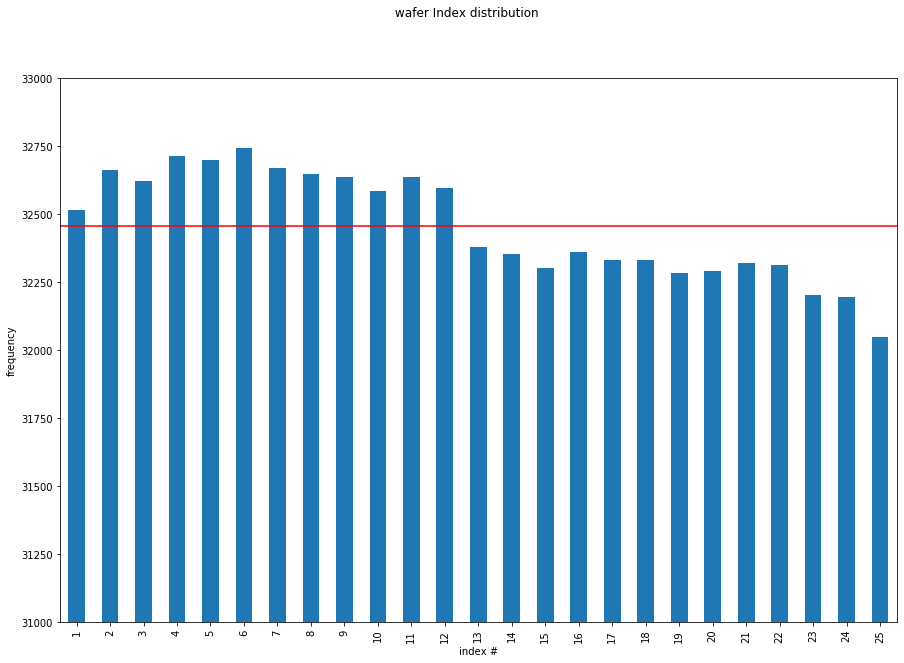

In [99]:
plot_wafer_index_distr(input_df);

## Data Transformation

### Cleansing

In [10]:
clean_df = input_df.drop('waferIndex', axis=1)

In [11]:
clean_df['waferMapDim'] = clean_df.waferMap.apply(lambda x: x.shape, meta=pd.Series({'waferMapDim': [(0, 0)]}))

In [12]:
clean_df[(clean_df.waferMapDim == (26, 26)) & (clean_df.failureType.apply(lambda x: len(x) > 0, meta=pd.Series({'x': [True]})))]

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
npartitions=100,,,,,,
0,object,float64,object,object,object,object
8115,...,...,...,...,...,...
...,...,...,...,...,...,...
803385,...,...,...,...,...,...
811456,...,...,...,...,...,...


Drop all maps with unequal dimensions, to avoid distortion when resizing

In [13]:
clean_df = clean_df[clean_df.waferMapDim.apply(lambda x: x[0] == x[1])]

Drop all unlabeled maps

In [14]:
clean_df['label'] = clean_df.failureType.apply(lambda x: x[0, 0] if (isinstance(x, np.ndarray) and x.shape[0] > 0) else 'unknown')
clean_df = clean_df[clean_df.label != "unknown"]

### Generate X and y

In [15]:
x = np.stack(clean_df.apply(
    lambda x: x.waferMap.reshape(
        (1, 26, 26)
    ) if x.waferMapDim[0] == 26 else cv2.resize(
        x.waferMap.reshape(x.waferMapDim[0], x.waferMapDim[1]), (26, 26)
    ).reshape(1, 26, 26), axis=1, meta=pd.Series({'x': [np.zeros((1, 26, 26))]})).compute().values)

In [16]:
y = clean_df.label.compute().values

In [17]:
print(f'x shape : {x.shape}, y shape : {y.shape}')

x shape : (22894, 1, 26, 26), y shape : (22894,)


Plot a sample of the results so far

In [442]:
label_dist = clean_df.groupby('label').size().compute()
inv_prob_label = {k: v for (k, v) in ((1/(label_dist/label_dist.sum()) )/((1/(label_dist/label_dist.sum()) ).sum())).iteritems()}

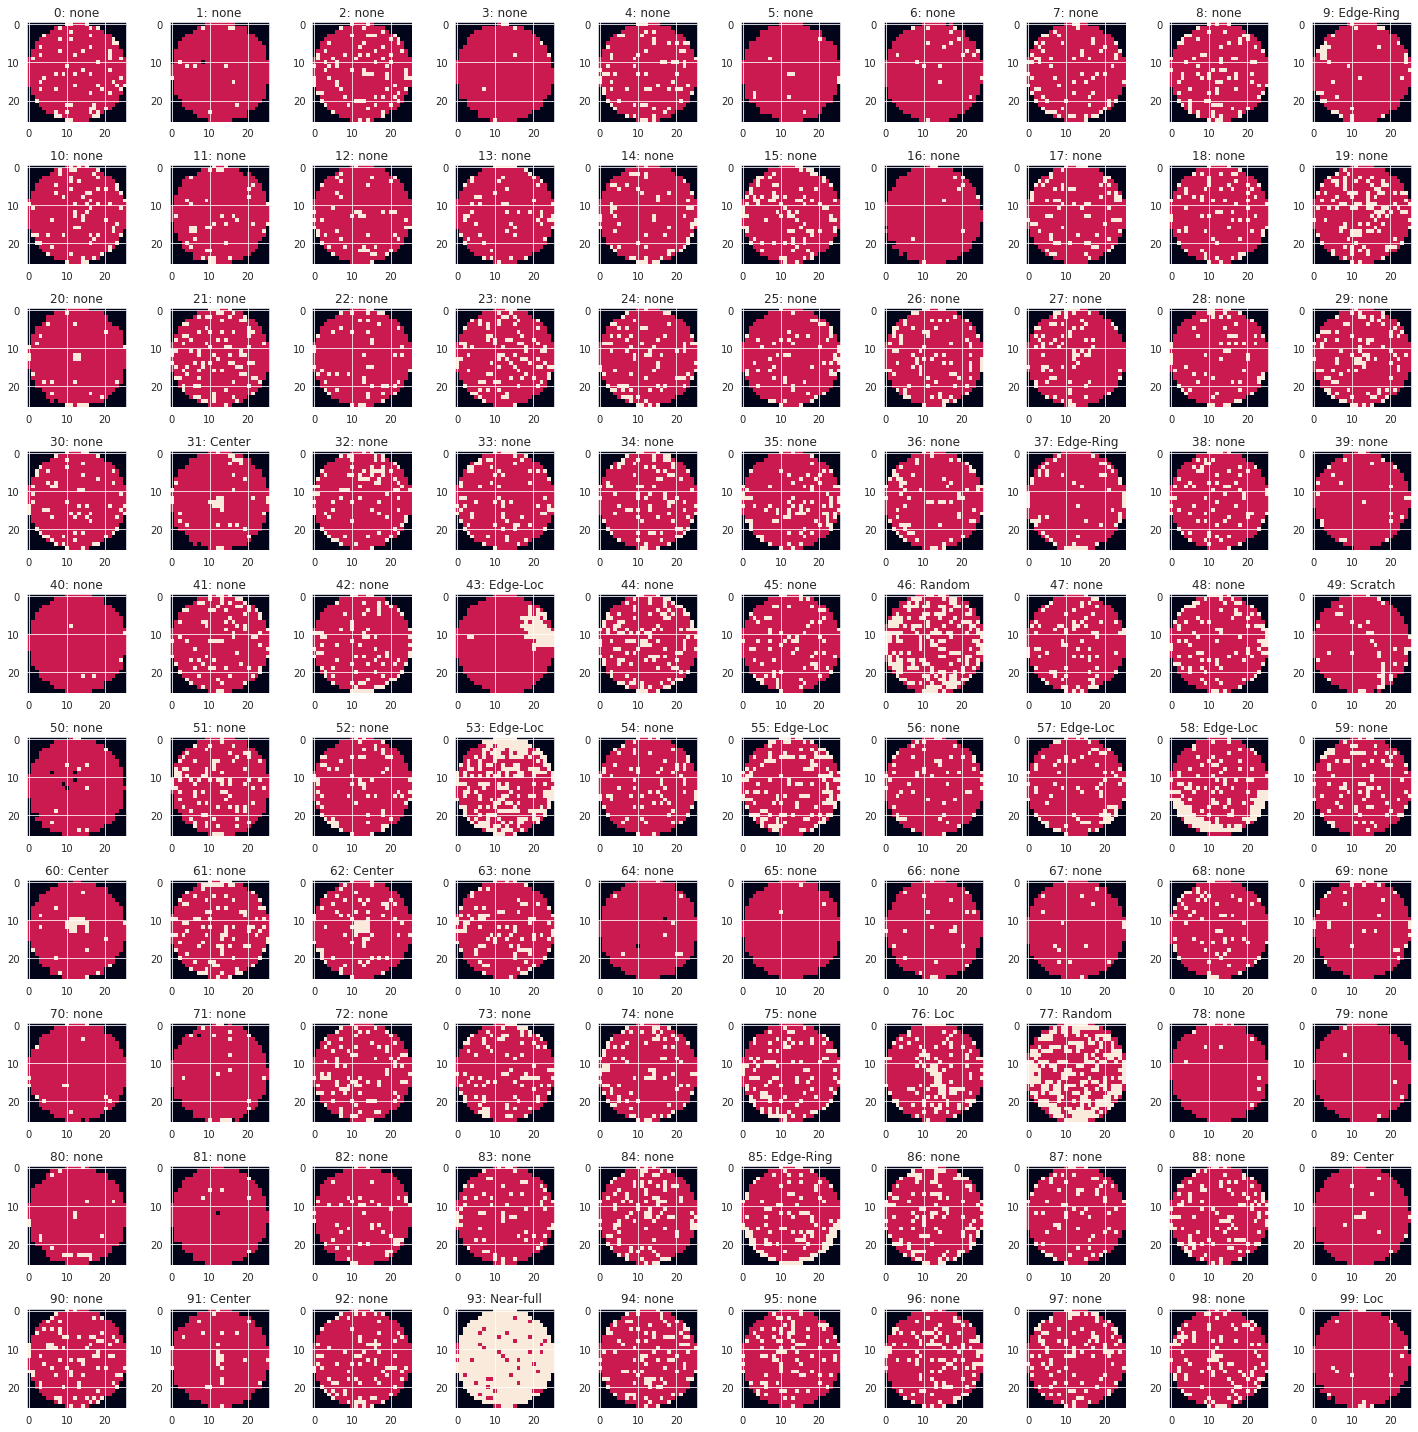

In [443]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
ax = ax.ravel(order="C")
for i, img_index in enumerate(np.random.choice(list(i for i, _ in enumerate(y)), 100, [inv_prob_label[label] for label in y])):
    img = x[img_index][0]
    ax[i].imshow(img)
    ax[i].set_title(f"{i}: {y[img_index]}", fontsize=12)
fig.tight_layout()
fig.show()

Even with upsampling, the good wafers completely dominage the picture - the bar chart below shows why. While that's good for business, a good model needs more balanced classes.

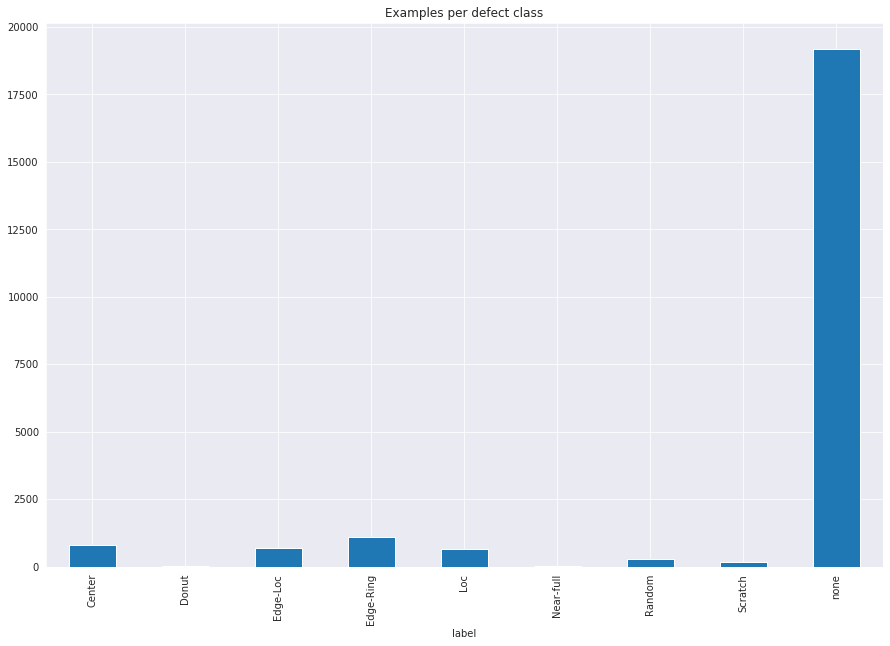

In [444]:
label_dist.plot.bar(title="Examples per defect class", figsize=(15, 10));

In [18]:
x = x.reshape((-1, 26, 26, 1))

In [19]:
def hot_encode(img_arr):
    new_arr = np.zeros((676, 3))
    for x in range(676):
        new_arr[x, img_arr[x]] = 1
    return new_arr.reshape((26, 26, 3))
    
new_x = np.apply_along_axis(hot_encode, axis=1, arr=x.reshape(-1, 26 * 26))

## Data Augmentation

In [20]:
def create_autoencoder(data, epochs, batch_size):
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)
    encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

    latent_vector = layers.MaxPool2D()(encode)

    # Decoder
    decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
    decode_layer_2 = layers.UpSampling2D()
    output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

    # connect decoder layers
    decode = decode_layer_1(latent_vector)
    decode = decode_layer_2(decode)

    ae = models.Model(input_tensor, output_tensor(decode))
    ae.compile(optimizer = 'Adam',
                  loss = 'mse',
                 )
#     ae.fit(data, data,
#        batch_size=batch_size,
#        epochs=epochs,
#        verbose=2)
    
    decoder_input = Input((13, 13, 64))
    decoder = decode_layer_1(decoder_input)
    decoder = decode_layer_2(decoder)
    
    return ae, models.Model(input_tensor, latent_vector), models.Model(decoder_input, output_tensor(decoder))

In [21]:
ae, encoder, decoder = create_autoencoder(new_x, epochs=15, batch_size=1024)

In [25]:
new_x.shape

(22894, 26, 26, 3)

In [449]:
encoded_x = encoder.predict(new_x)
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

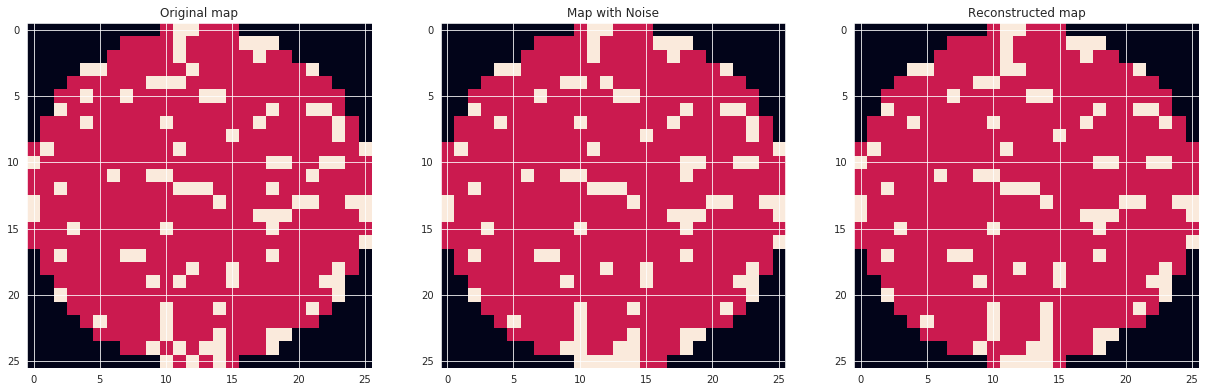

In [450]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

ax[0].imshow(np.argmax(new_x[3], axis=2));
ax[0].set_title("Original map")
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
ax[1].imshow(noised_gen_x[3])
ax[1].set_title("Map with Noise")
gen_x = np.argmax(ae.predict(new_x), axis=3)
ax[2].imshow(gen_x[3])
ax[2].set_title("Reconstructed map")
fig.show()

In [507]:
def gen_data(wafer, label, n_examples=2000):
    # Encode input wafer
    print(f"There are {len(wafer)} examples for {label}")
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    
    additional_example_batches = n_examples // wafer.shape[0] + 1
    temp_noised = []
    for i in range(additional_example_batches):
        temp_noised.append(encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)))
    noised_encoded_x = np.vstack(temp_noised)
    gen_x = decoder.predict(noised_encoded_x[1:])
    # also make label vector with same length
    gen_y = np.full((len(gen_x), ), label)

    print(f"Returning {n_examples - len(wafer)} new examples") 
    return gen_x[1:n_examples+1], gen_y[1:n_examples+1]

In [508]:
label_classes = {l: i for (i, l) in enumerate(label_dist.index.values)}

def augment_data(x, y, labels):
    aug_x = x.copy()
    aug_y = y.copy()
    for f in labels: 
        # skip none case
        if f in {'none', 'unknown'} : 
            continue
        else:
            print(f'Generating {f}')

        gen_x, gen_y = gen_data(x[np.where(y==f)[0]], f, 15000)
        aug_x = np.concatenate((aug_x, gen_x), axis=0)
        aug_y = np.concatenate((aug_y, gen_y))
    return aug_x, aug_y

In [509]:
aug_x, aug_y = augment_data(new_x, y, list(label_classes.keys()))

Generating Center
There are 803 examples for Center
(15257, 13, 13, 64)
Returning 14197 new examples
Generating Donut
There are 14 examples for Donut
(15008, 13, 13, 64)
Returning 14986 new examples
Generating Edge-Loc
There are 680 examples for Edge-Loc
(15640, 13, 13, 64)
Returning 14320 new examples
Generating Edge-Ring
There are 1093 examples for Edge-Ring
(15302, 13, 13, 64)
Returning 13907 new examples
Generating Loc
There are 634 examples for Loc
(15216, 13, 13, 64)
Returning 14366 new examples
Generating Near-full
There are 32 examples for Near-full
(15008, 13, 13, 64)
Returning 14968 new examples
Generating Random
There are 282 examples for Random
(15228, 13, 13, 64)
Returning 14718 new examples
Generating Scratch
There are 165 examples for Scratch
(15015, 13, 13, 64)
Returning 14835 new examples


## Training

In [525]:
aug_y = to_categorical([label_classes[label] for label in aug_y])

x_train, x_test, y_train, y_test = train_test_split(aug_x, aug_y, test_size=0.33, random_state=42)

In [526]:
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [527]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2)
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
results = cross_val_score(model, x_train, y_train, cv=kfold)
print(f"CV Score: {np.mean(results)}")

Train on 63825 samples
Epoch 1/10
63825/63825 - 4s - loss: 0.7473 - accuracy: 0.7497
Epoch 2/10
63825/63825 - 4s - loss: 0.1907 - accuracy: 0.9464
Epoch 3/10
63825/63825 - 4s - loss: 0.0316 - accuracy: 0.9921
Epoch 4/10
63825/63825 - 4s - loss: 0.0131 - accuracy: 0.9970
Epoch 5/10
63825/63825 - 4s - loss: 0.0104 - accuracy: 0.9974
Epoch 6/10
63825/63825 - 4s - loss: 0.0068 - accuracy: 0.9987
Epoch 7/10
63825/63825 - 4s - loss: 0.0053 - accuracy: 0.9989
Epoch 8/10
63825/63825 - 4s - loss: 0.0034 - accuracy: 0.9995
Epoch 9/10
63825/63825 - 4s - loss: 0.0036 - accuracy: 0.9995
Epoch 10/10
63825/63825 - 4s - loss: 0.0030 - accuracy: 0.9995
31913/31913 - 1s - loss: 0.0204 - accuracy: 0.9942
Train on 63825 samples
Epoch 1/10
63825/63825 - 4s - loss: 0.8628 - accuracy: 0.7079
Epoch 2/10
63825/63825 - 4s - loss: 0.1207 - accuracy: 0.9648
Epoch 3/10
63825/63825 - 4s - loss: 0.0338 - accuracy: 0.9923
Epoch 4/10
63825/63825 - 4s - loss: 0.3300 - accuracy: 0.9261
Epoch 5/10
63825/63825 - 4s - loss

In [529]:
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=7,
         batch_size=1024,
         )

Train on 95738 samples, validate on 47156 samples
Epoch 1/7
95738/95738 - 8s - loss: 0.6007 - accuracy: 0.7995 - val_loss: 0.0926 - val_accuracy: 0.9733
Epoch 2/7
95738/95738 - 7s - loss: 0.0385 - accuracy: 0.9906 - val_loss: 0.0316 - val_accuracy: 0.9937
Epoch 3/7
95738/95738 - 7s - loss: 0.0159 - accuracy: 0.9958 - val_loss: 0.0160 - val_accuracy: 0.9955
Epoch 4/7
95738/95738 - 7s - loss: 0.2154 - accuracy: 0.9558 - val_loss: 0.0384 - val_accuracy: 0.9894
Epoch 5/7
95738/95738 - 7s - loss: 0.0137 - accuracy: 0.9966 - val_loss: 0.0176 - val_accuracy: 0.9951
Epoch 6/7
95738/95738 - 7s - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0165 - val_accuracy: 0.9953
Epoch 7/7
95738/95738 - 7s - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0193 - val_accuracy: 0.9947


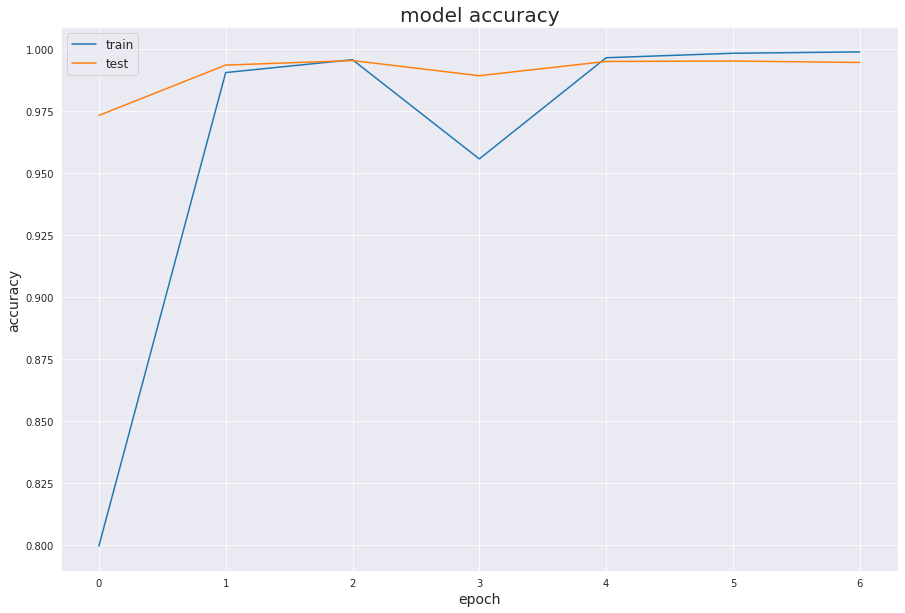

In [530]:
# accuracy plot 
import seaborn as sns
sns.set_style(style='darkgrid')
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy', fontsize=20)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'test'], loc='upper left', fontsize=12)
plt.show()

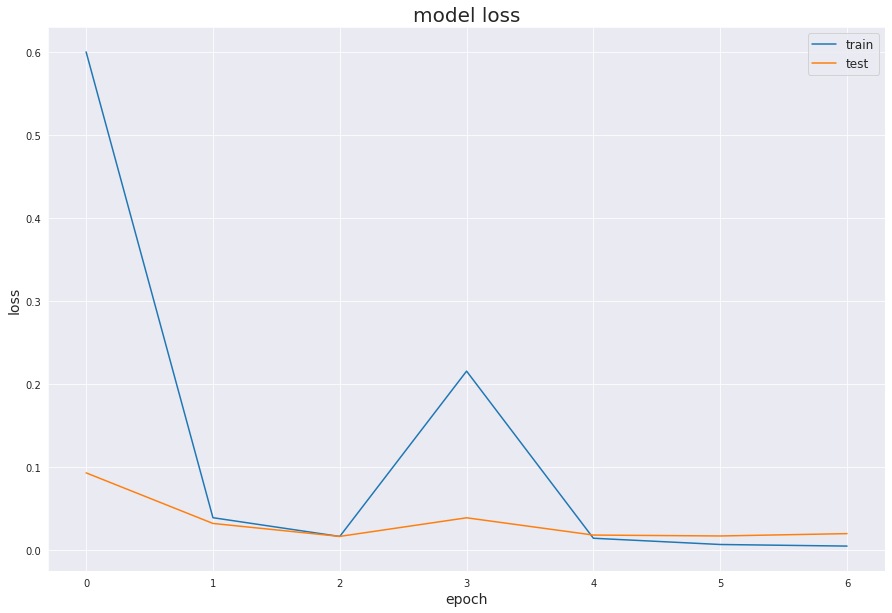

In [531]:
# loss plot
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend(['train', 'test'], loc='upper right', fontsize=12)
plt.show()